[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [38]:
import pandas as pd
import numpy as np
import warnings
import geopandas as gpd
from dbfread import DBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
import shap
import math
from sklearn.inspection import PartialDependenceDisplay

### Load data

In [39]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


### filter max and min of ros_p

In [40]:
#df = df[df["ros_p"] < 3000]
#df = df[df["ros_p"] > 500]

### remove nans from ros_p

In [41]:
n_before = len(df)
df = df.dropna(subset=['ros_p']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1173


### convert categorical variables into "category" type

In [42]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Turn ros lags into log

In [43]:
log_base = 10

ros_lag_cols = [col for col in df.columns if col.startswith('ros_p_lg')]

for col in ros_lag_cols:
    log_col = f'{col}_log'
    df[log_col] = np.where(
        df[col] > 0,
        np.log1p(df[col]) / np.log(log_base),
        np.nan
    )

df.drop(columns=ros_lag_cols, inplace=True)

### Select specific columns for modeling

In [44]:
c = [
    "duration_p",
    "ros_p_lg1_log",
    "8_ny_fir_p",
    "sW_100_av",
    "3_8y_fir_p",
    "HDW_av",
    "f_load_av",
    "gT_s_9_av",
    "landform",
    "gT_8_7_av",
    "aspect_av",
    "wv100_av",
    "BLH_m_rt",
    "Cape_av",
    "wv_850_av",
    "1_3y_fir_p",
    "rh_950_av",
    "wv_500_av",
    "gp_m2s2_av",
    "wdi_300_av",
    "ros_p"
]

df = df[c]

### Drop top 10 vars with highest sum of correlation

In [45]:
"""# Select only numerical vars
num_df = df.select_dtypes(include=["number"])

# Calculate corr matrix
corr_matrix = num_df.corr()

# Sum of absolute correlations
corr_sum = corr_matrix.abs().sum()

# Sort by correlation sum
corr_sum = corr_sum.sort_values(ascending=False, kind="mergesort")

print(corr_sum)

# change number to change n of top vars to drop
drop = corr_sum.index[:20].tolist()

print("\nVariables removed:")
print(drop)

df = df.drop(columns=drop)"""

'# Select only numerical vars\nnum_df = df.select_dtypes(include=["number"])\n\n# Calculate corr matrix\ncorr_matrix = num_df.corr()\n\n# Sum of absolute correlations\ncorr_sum = corr_matrix.abs().sum()\n\n# Sort by correlation sum\ncorr_sum = corr_sum.sort_values(ascending=False, kind="mergesort")\n\nprint(corr_sum)\n\n# change number to change n of top vars to drop\ndrop = corr_sum.index[:20].tolist()\n\nprint("\nVariables removed:")\nprint(drop)\n\ndf = df.drop(columns=drop)'

### Eliminate vars with >50% rows with nans

In [ ]:
"""df = df.drop(
    columns=["EL_m_av", "Cin_av", "gT_s_9_av", "rh_700_av", "LiftIdx_av"],
    errors="ignore"
)"""

### Create test and train datasets

In [47]:
# change test_size value to change validdation dataset %
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]

X_train = df_train[train_features].copy()
X_test = df_test[train_features].copy()
y_train = df_train['ros_p'].copy()
y_test = df_test['ros_p'].copy()

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# Remove invalid targets (-1 values)
valid_train = y_train != -1
valid_test = y_test != -1

X_train_final = X_train[valid_train].reset_index(drop=True)
y_train_final = y_train[valid_train].reset_index(drop=True)

X_test_final = X_test[valid_test].reset_index(drop=True)
y_test_final = y_test[valid_test].reset_index(drop=True)

# Save datasets
#X_train_final.to_csv('X_train_with_lags.csv', index=False)
#y_train_final.to_csv('y_train_with_lags.csv', index=False)
#X_test_final.to_csv('X_test_with_lags.csv', index=False)  
#y_test_final.to_csv('y_test_with_lags.csv', index=False)

Training set size: 938
Test set size: 235


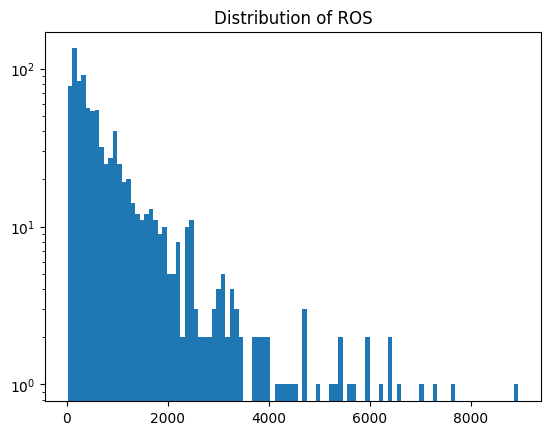

In [48]:
# Plot distribution of y_train_final (ros_p)
plt.hist(y_train_final, bins=100)
plt.yscale('log')
plt.title("Distribution of ROS")
plt.show()

### XGBoost model

In [49]:
# modify constants below in order to change transformation of ros_p. (don't forget to apply the same transformation to ros_p lags above)
log_mult = 1 #23.3139 
log_base = 10 #2.9637

y_train_log = log_mult *  np.log1p(y_train_final) / np.log(log_base)
y_test_log = log_mult * np.log1p(y_test_final) / np.log(log_base)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 300
max_resources_: 3000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 300
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:0.41964
[1]	validation_0-rmse:0.39009
[2]	validation_0-rmse:0.37478
[3]	validation_0-rmse:0.35361
[4]	validation_0-rmse:0.34120
[5]	validation_0-rmse:0.33124
[0]	validation_0-rmse:0.39888
[6]	validation_0-rmse:0.32554
[7]	validation_0-rmse:0.32082
[8]	validation_0-rmse:0.31855
[9]	validation_0-rmse:0.31766
[1]	validation_0-rmse:0.34539
[10]	validation_0-rmse:0.31709
[11]	validation_0-rmse:0.31715
[2]	validation_0-rmse:0.30936
[12]	validation_0-rmse:0.31624
[13]	validation_0-rmse:0.31472
[14]	validation_0-rmse:0.31277
[15]	validation_0-rmse:0.31292
[3]	validation_0-rmse:0.28374
[16]	validation_0-rmse:0.31331
[17]	validation_0-rmse:0.31469
[18]	validation_0-rmse:0.31515
[19]	validation_0-rmse:0.31530
[20]	vali

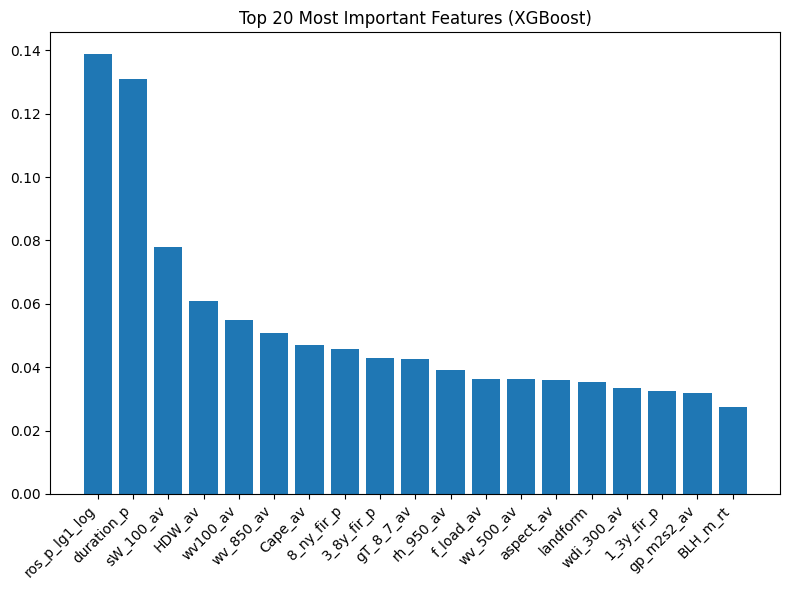


Top 20 Most Important Features:
          feature  importance
1   ros_p_lg1_log    0.138735
0      duration_p    0.131019
3       sW_100_av    0.077847
5          HDW_av    0.060790
10       wv100_av    0.054793
13      wv_850_av    0.050800
12        Cape_av    0.046888
2      8_ny_fir_p    0.045777
4      3_8y_fir_p    0.042952
8       gT_8_7_av    0.042423
15      rh_950_av    0.039008
6       f_load_av    0.036278
16      wv_500_av    0.036132
9       aspect_av    0.035992
7        landform    0.035299
18     wdi_300_av    0.033478
14     1_3y_fir_p    0.032568
17     gp_m2s2_av    0.031745
11       BLH_m_rt    0.027476


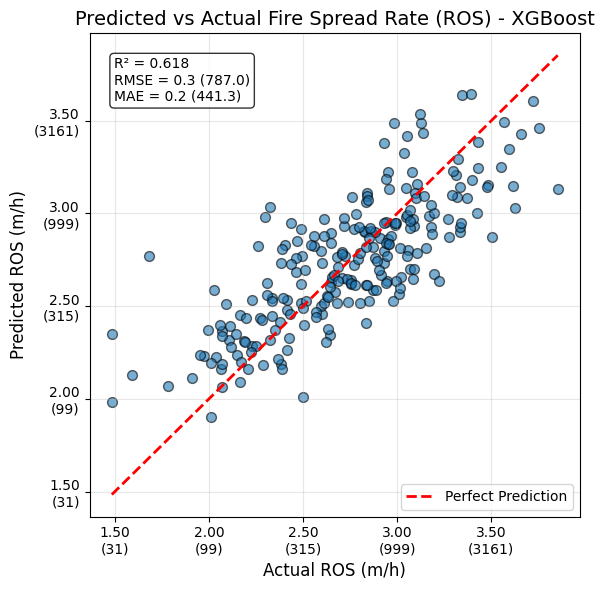

In [50]:
param_dist = {
    'max_depth': [5, 7, 9, 11, 13, 15],               # tree depth
    'learning_rate': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)
    'subsample': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)
    'colsample_bylevel': uniform(0.6, 0.4),           # column sampling per level (adds complexity)
    'colsample_bynode': uniform(0.6, 0.4),            # column sampling per node (adds complexity)
    'min_child_weight': randint(1, 10),               # minimum sum of instance weight in a child
    'gamma': uniform(0, 0.5),                         # minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(1, 3),                      # L2 regularization (increased range)
    'max_delta_step': randint(0, 5),                  # maximum delta step (helps with imbalanced data)
}

# XGBoost model with early stopping
base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',                               # faster histogram-based algorithm
    early_stopping_rounds=50,                         # stop if no improvement
    enable_categorical=True                           # handle categorical features better
)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Halving random search with more resources
xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                                         # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=3000,                            
    min_resources=300,                           
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model search with validation set for early stopping
xgb_random.fit(
    X_train_final, 
    y_train_log,
    eval_set=[(X_train_final, y_train_log)]
)

# Get the best model and parameters
print(f"\nSearch complete.")
print(f"Best parameters found: {xgb_random.best_params_}")
best_model = xgb_random.best_estimator_

# Make predictions with the best model
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

# Inverse transform log to linear
inv_mult = np.log(log_base) / log_mult
y_test_linear = np.exp(y_test_log * inv_mult) - 1
y_pred_linear = np.exp(y_pred_log * inv_mult) - 1

# Metrics in log space
r2 = r2_score(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae_log = mean_absolute_error(y_test_log, y_pred_log)

# Metrics in linear space
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

# Feature importance
feature_names = X_train_final.columns.tolist()
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

print("\nLog scale metrics:")
print(f"R2 Score (log): {r2:.4f}")
print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")
print(f"\nBest n_estimators: {best_model.n_estimators}")
print(f"Best max_depth: {best_model.max_depth}")

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Features:")
print(importances.head(20))

# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_log.min(), y_pred_log.min())
max_val = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Fire Spread Rate (ROS) - XGBoost', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation with both log and linear scales
plt.text(0.05, 0.95, 
    f'R² = {r2:.3f}\n'
    f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
    f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# inverse-transform scaling factor
inv_mult = np.log(log_base) / log_mult

def tick_formatter_log_to_linear(x, pos):
    """Formats tick: log_value  (linear_value)"""
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Randomly sample 10 rows to see model prediction and corresponding error

In [51]:
sample_df = pd.DataFrame({
    'Actual ROS': y_test_linear,
    'Predicted ROS': y_pred_linear
}).reset_index(drop=True)

# Randomly sample 10 rows
sample_10 = sample_df.sample(10).copy()

# Compute % error
sample_10['% Error'] = ((sample_10['Predicted ROS'] - sample_10['Actual ROS']) / sample_10['Actual ROS']) * 100

print("Sample of 10 predictions vs actual ROS values:\n")
display(sample_10)

Sample of 10 predictions vs actual ROS values:



Actual ROS  Predicted ROS     % Error
218  2152.215344    1385.987155  -35.601837
48    727.377197     801.704244   10.218501
147   360.024228     670.616346   86.269782
63   2155.199053     789.207810  -63.381210
104  3578.771455    1770.904315  -50.516418
231   155.081113     202.814509   30.779632
124   240.142751     153.288060  -36.167942
83    894.552457    1674.515740   87.190335
57    253.773983     674.065173  165.616343
222    88.861732     172.002781   93.562264


SHAP Analysis


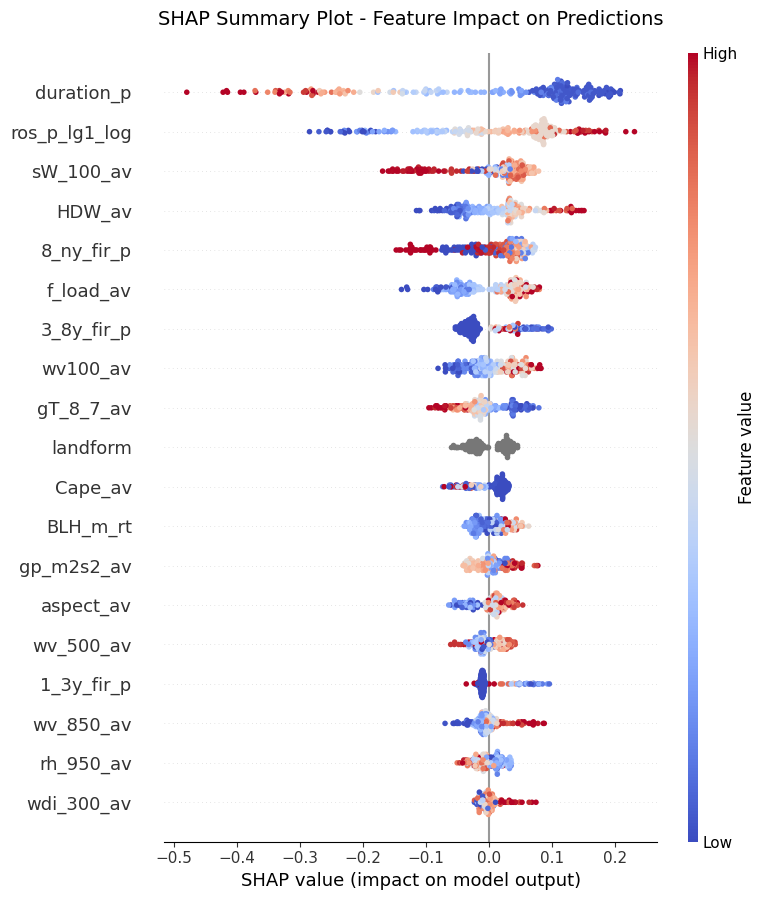

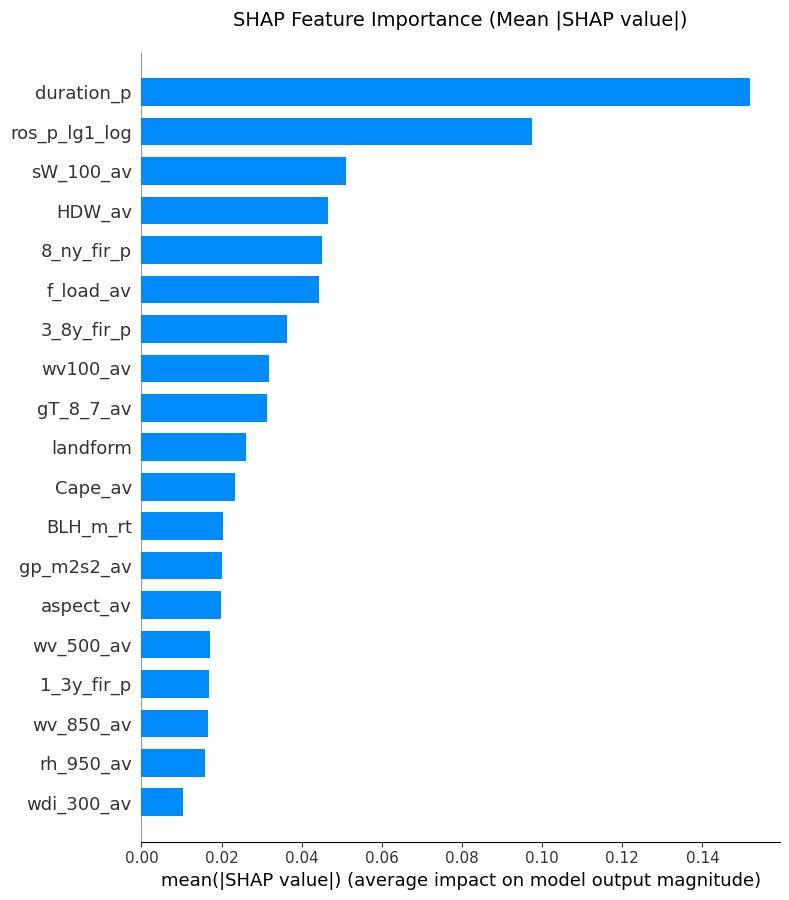

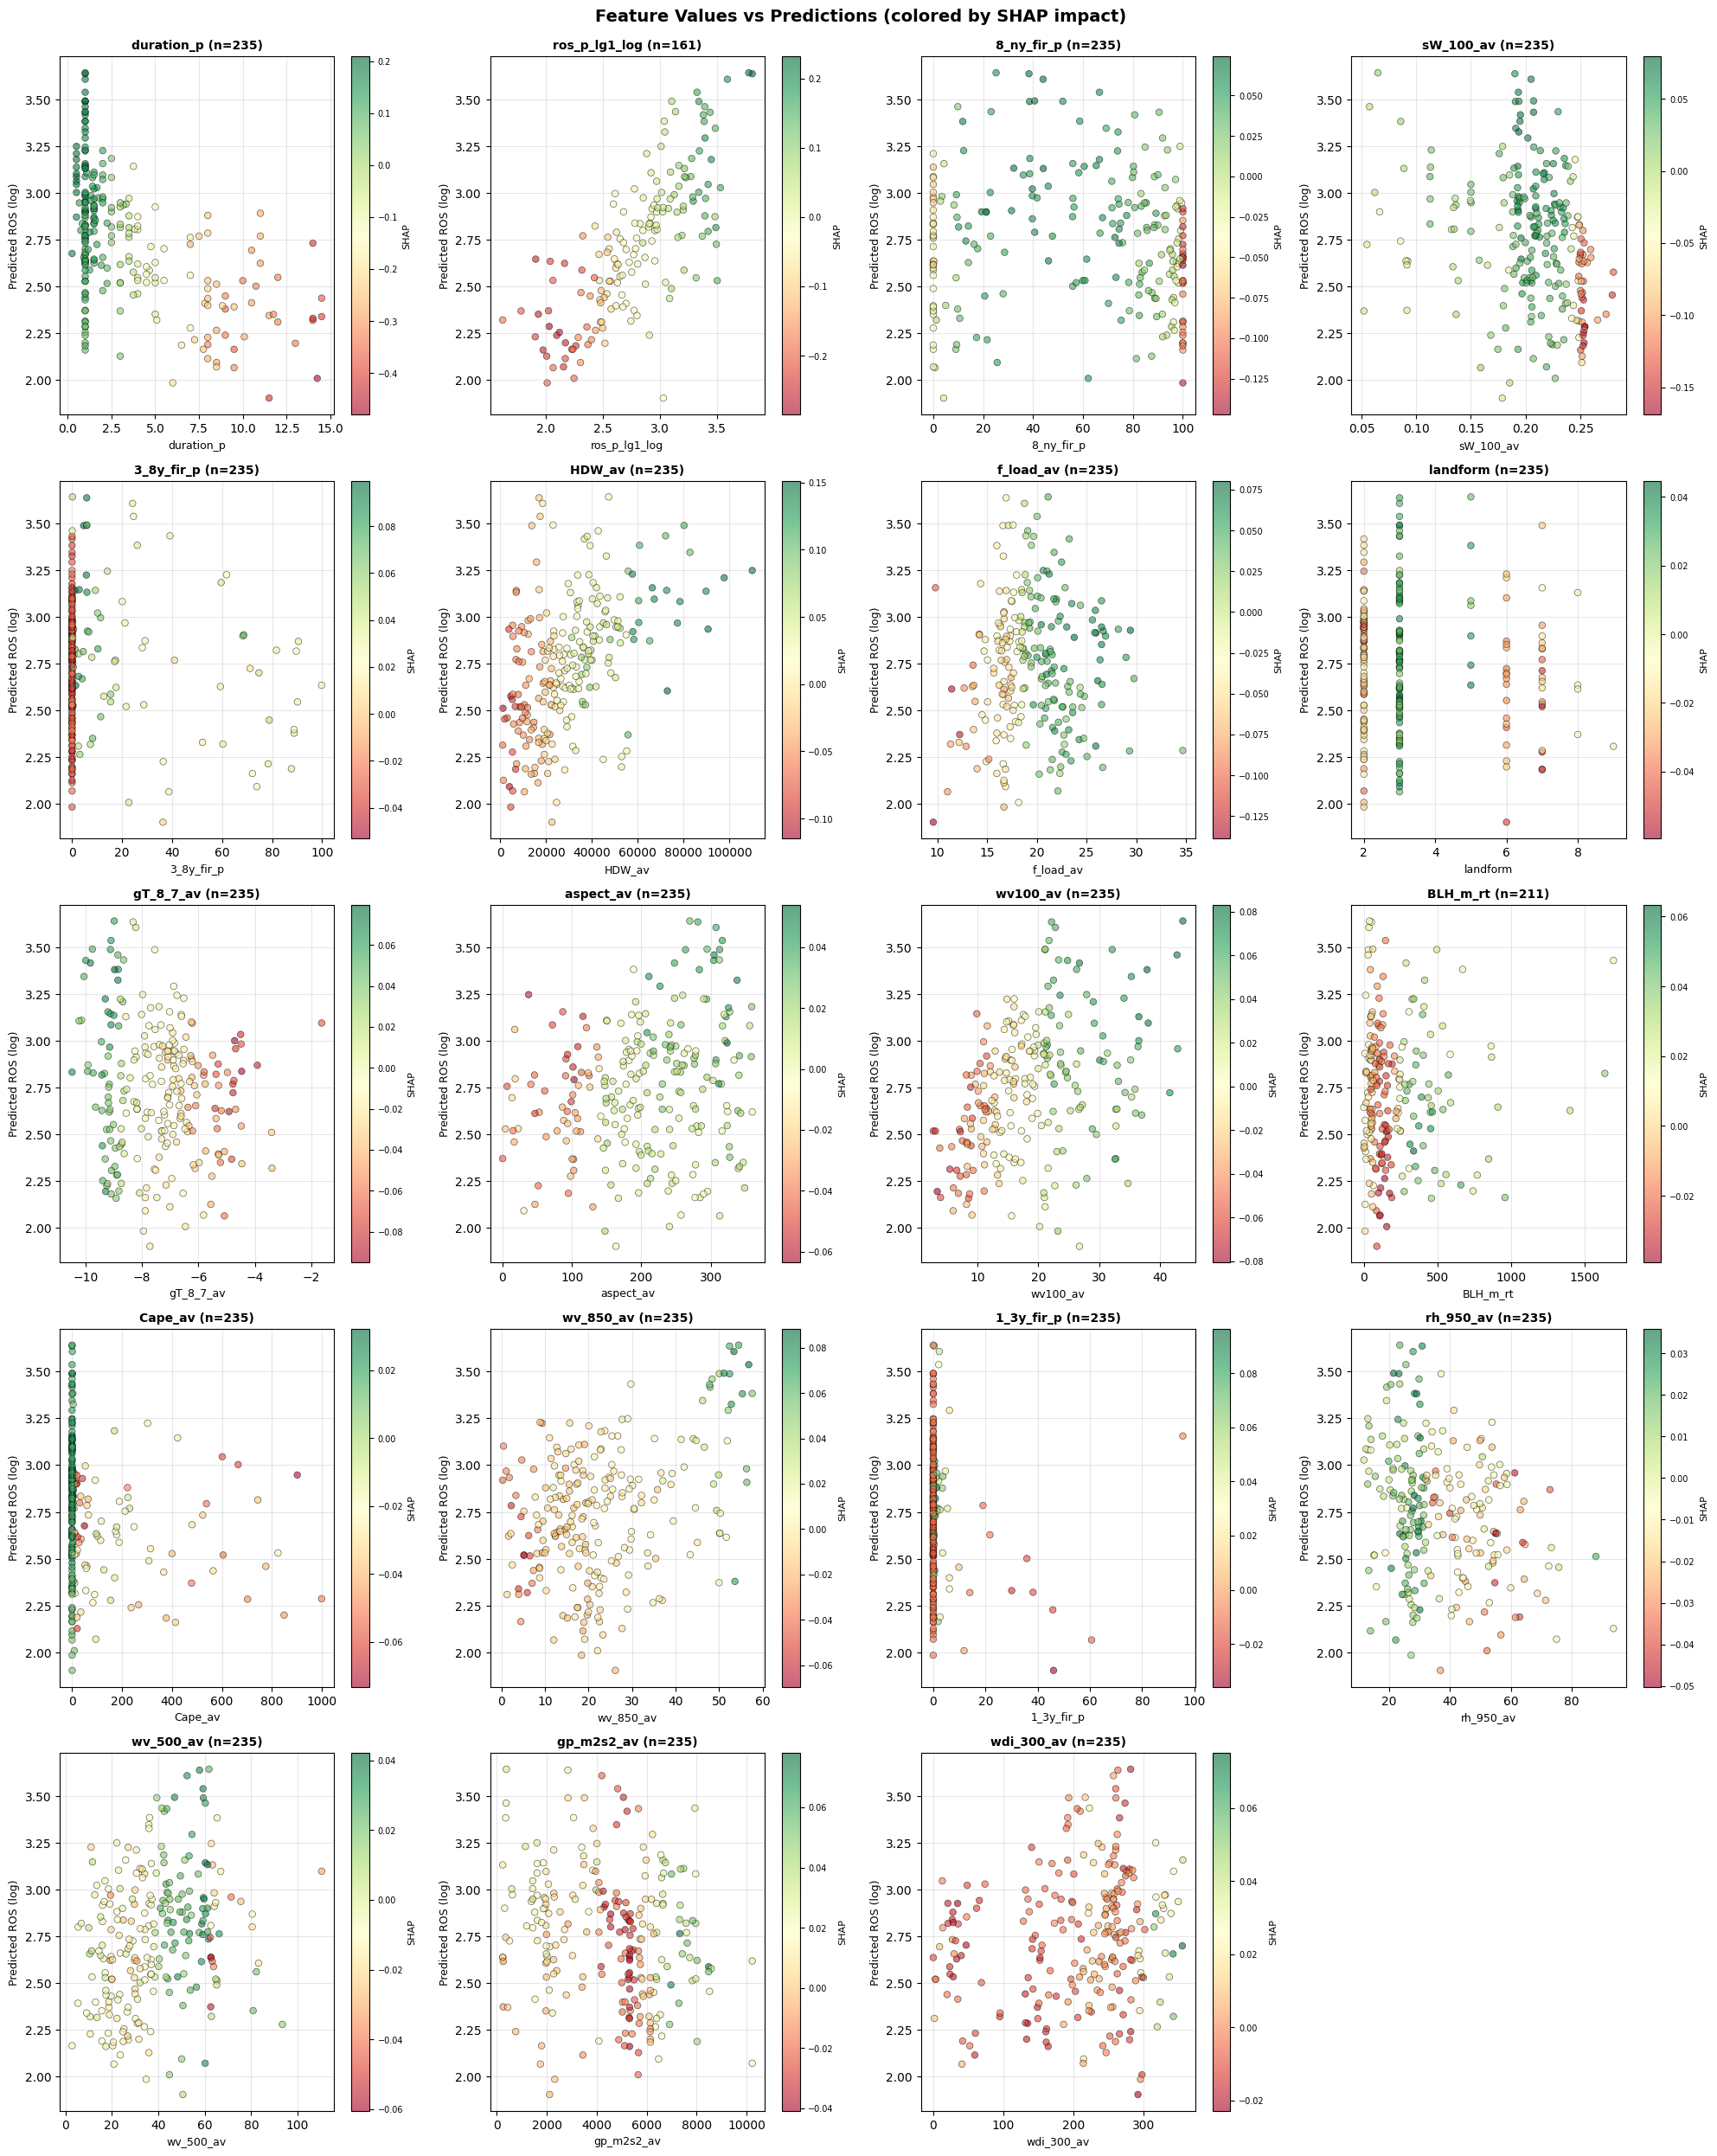

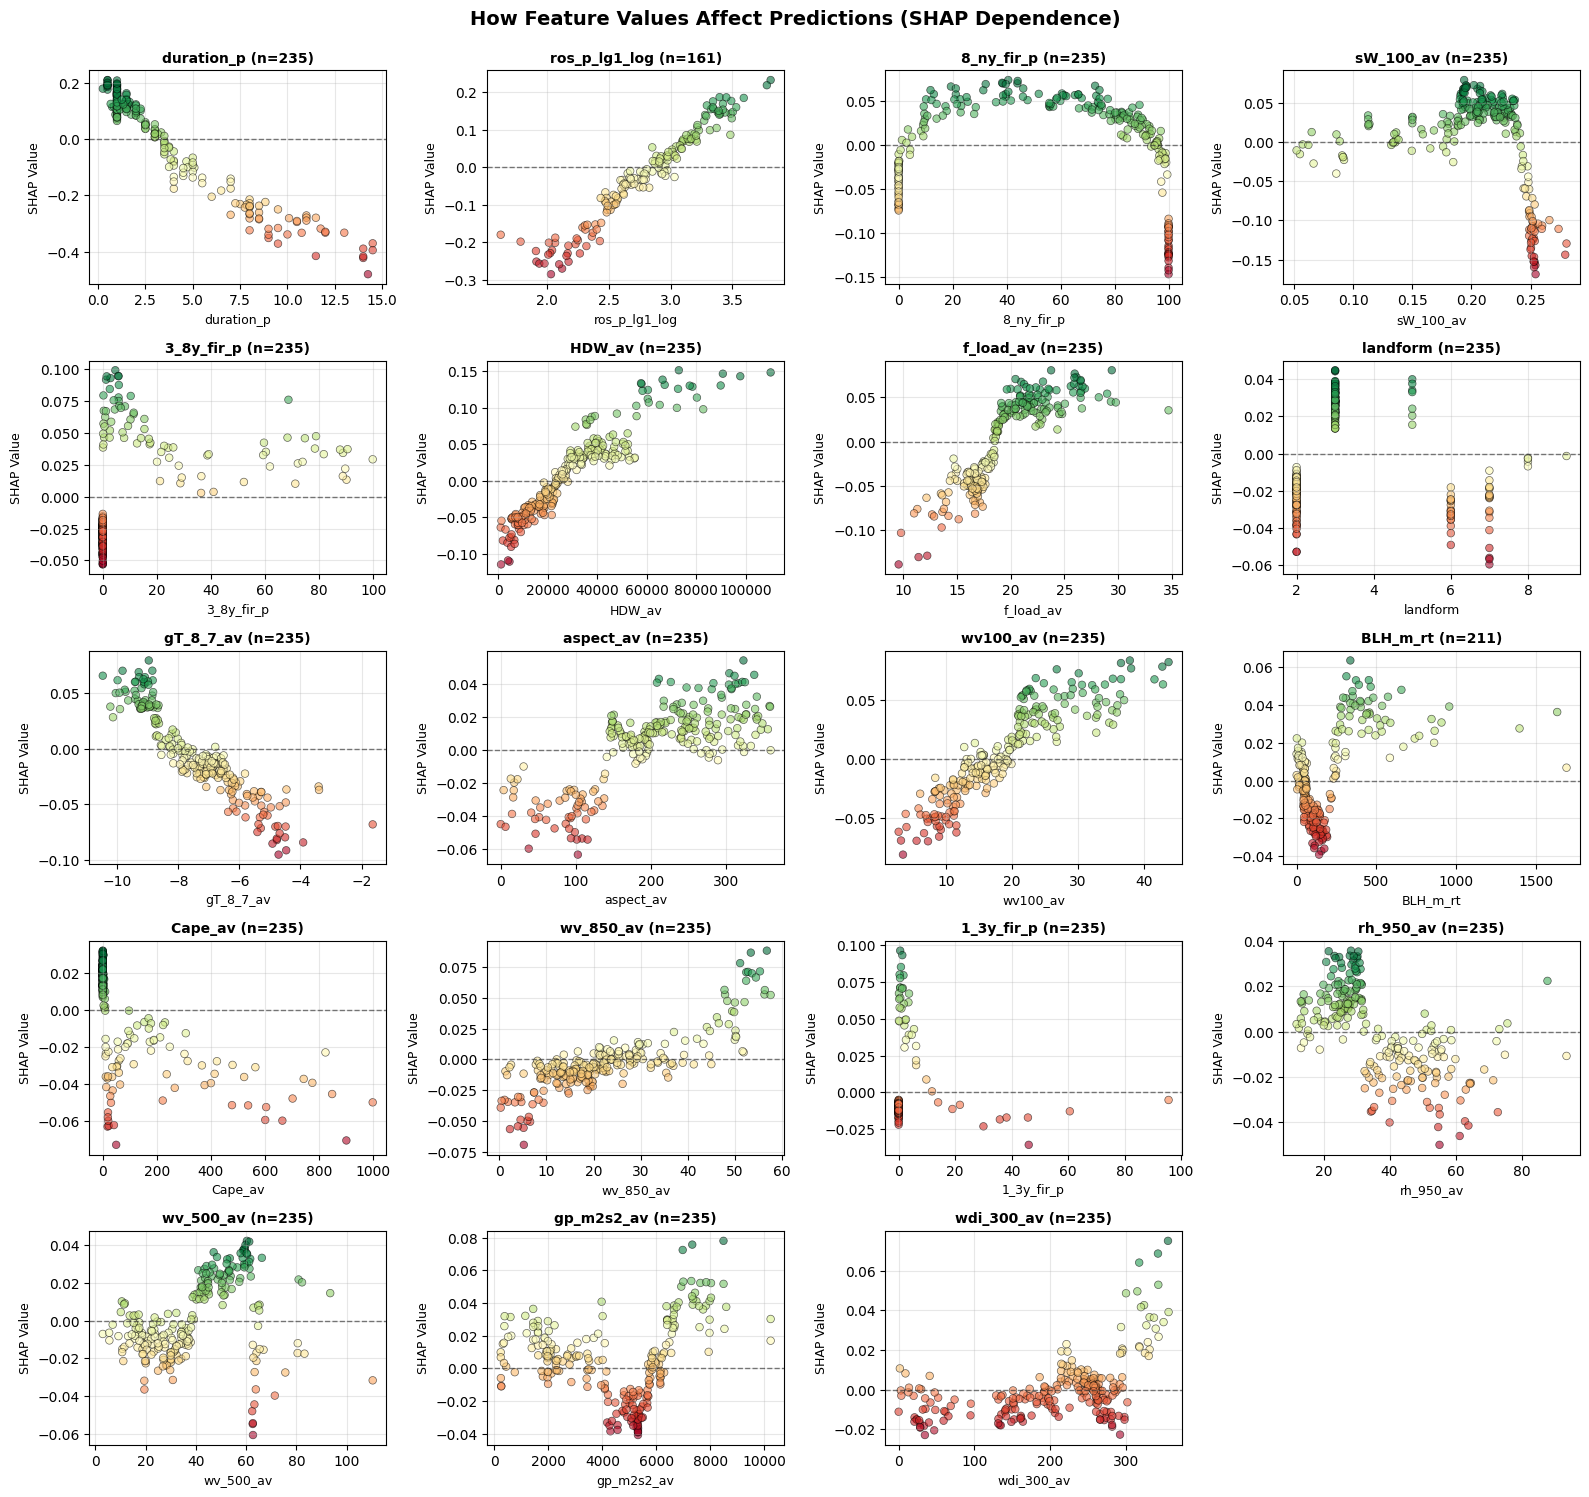


Top 20 Features by Mean |SHAP value|:
          feature  mean_abs_shap
0      duration_p       0.151769
1   ros_p_lg1_log       0.097428
3       sW_100_av       0.051100
5          HDW_av       0.046610
2      8_ny_fir_p       0.045037
6       f_load_av       0.044430
4      3_8y_fir_p       0.036398
10       wv100_av       0.031825
8       gT_8_7_av       0.031219
7        landform       0.026056
12        Cape_av       0.023347
11       BLH_m_rt       0.020268
17     gp_m2s2_av       0.020157
9       aspect_av       0.019955
16      wv_500_av       0.017037
14     1_3y_fir_p       0.016974
13      wv_850_av       0.016539
15      rh_950_av       0.015895
18     wdi_300_av       0.010432

Comparison: XGBoost Importance vs SHAP Importance (Top 15):
          feature  importance  mean_abs_shap
1      duration_p    0.131019       0.151769
0   ros_p_lg1_log    0.138735       0.097428
2       sW_100_av    0.077847       0.051100
3          HDW_av    0.060790       0.046610
7      8_ny_fir

In [52]:
print("\n" + "="*50)
print("SHAP Analysis")
print("="*50)

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_final)

# 1. Summary Plot (only remove NaN for color mapping, not for SHAP values)
# Create a copy for display that handles NaN coloring
X_test_display = X_test_final.copy()
for col in X_test_display.columns:
    if X_test_display[col].isna().any():
        X_test_display[col] = X_test_display[col].fillna(X_test_display[col].median())

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_display, plot_type="dot", show=False, cmap='coolwarm')
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. Bar Plot (alternative view of feature importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_display, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Get all features
all_features = X_test_final.columns.tolist()
n_features = len(all_features)

# Dynamically calculate rows and columns for subplots
n_cols = 4  # keep 4 columns
n_rows = math.ceil(n_features / n_cols)

# -----------------------------
# 1. Scatter Plots: Feature vs Prediction (colored by SHAP)
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(all_features):
    ax = axes[idx]
    
    # Feature values and SHAP values
    feature_values = X_test_final[feature].values
    feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
    
    # Handle different data types for cleaning
    if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
        # For categorical data, check for NaN/None values
        valid_mask = pd.notna(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        y_pred_clean = y_pred_log[valid_mask]
        
        # Convert categorical to numeric for plotting if needed
        if X_test_final[feature].dtype.name == 'category':
            feature_values_clean = pd.Categorical(feature_values_clean).codes
    else:
        # For numerical data, use the original approach
        valid_mask = ~np.isnan(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        y_pred_clean = y_pred_log[valid_mask]
    
    # Scatter plot
    scatter = ax.scatter(
        feature_values_clean,
        y_pred_clean,
        c=feature_shap_clean,
        cmap='RdYlGn',
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.5
    )
    
    ax.set_xlabel(f'{feature}', fontsize=9)
    ax.set_ylabel('Predicted ROS (log)', fontsize=9)
    ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('SHAP', fontsize=8)
    cbar.ax.tick_params(labelsize=7)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Feature Values vs Predictions (colored by SHAP impact)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Dependence Plots: Feature vs SHAP Value
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(all_features):
    ax = axes[idx]
    
    feature_values = X_test_final[feature].values
    feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
    
    # Handle different data types for cleaning (FIXED HERE TOO)
    if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
        # For categorical data, check for NaN/None values
        valid_mask = pd.notna(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        
        # Convert categorical to numeric for plotting if needed
        if X_test_final[feature].dtype.name == 'category':
            feature_values_clean = pd.Categorical(feature_values_clean).codes
    else:
        # For numerical data, use the original approach
        valid_mask = ~np.isnan(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
    
    # Scatter plot
    scatter = ax.scatter(
        feature_values_clean,
        feature_shap_clean,
        c=feature_shap_clean,
        cmap='RdYlGn',
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Zero line
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel(f'{feature}', fontsize=9)
    ax.set_ylabel('SHAP Value', fontsize=9)
    ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('How Feature Values Affect Predictions (SHAP Dependence)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 6. Mean absolute SHAP values (alternative to feature importance)
shap_importance = pd.DataFrame({
    'feature': X_test_final.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values('mean_abs_shap', ascending=False)

print("\nTop 20 Features by Mean |SHAP value|:")
print(shap_importance.head(20))

# Compare SHAP importance vs XGBoost importance
comparison = importances.merge(
    shap_importance, 
    on='feature', 
    suffixes=('_xgb', '_shap')
)
comparison = comparison.sort_values('mean_abs_shap', ascending=False)

print("\nComparison: XGBoost Importance vs SHAP Importance (Top 15):")
print(comparison[['feature', 'importance', 'mean_abs_shap']].head(15))

# Check for missing values in top features
print("\nMissing values in top 10 features:")
for feature in importances['feature'][:10]:
    missing_count = X_test_final[feature].isna().sum()
    missing_pct = 100 * missing_count / len(X_test_final)
    if missing_count > 0:
        print(f"{feature}: {missing_count} ({missing_pct:.1f}%)")


Partial Dependence Plots (PDPs)

Numerical features: 18
Categorical features: 1
Categorical: landform

Creating PDPs for top 10 numerical features...


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/inspection/_plot/partial_dependence.py:995: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


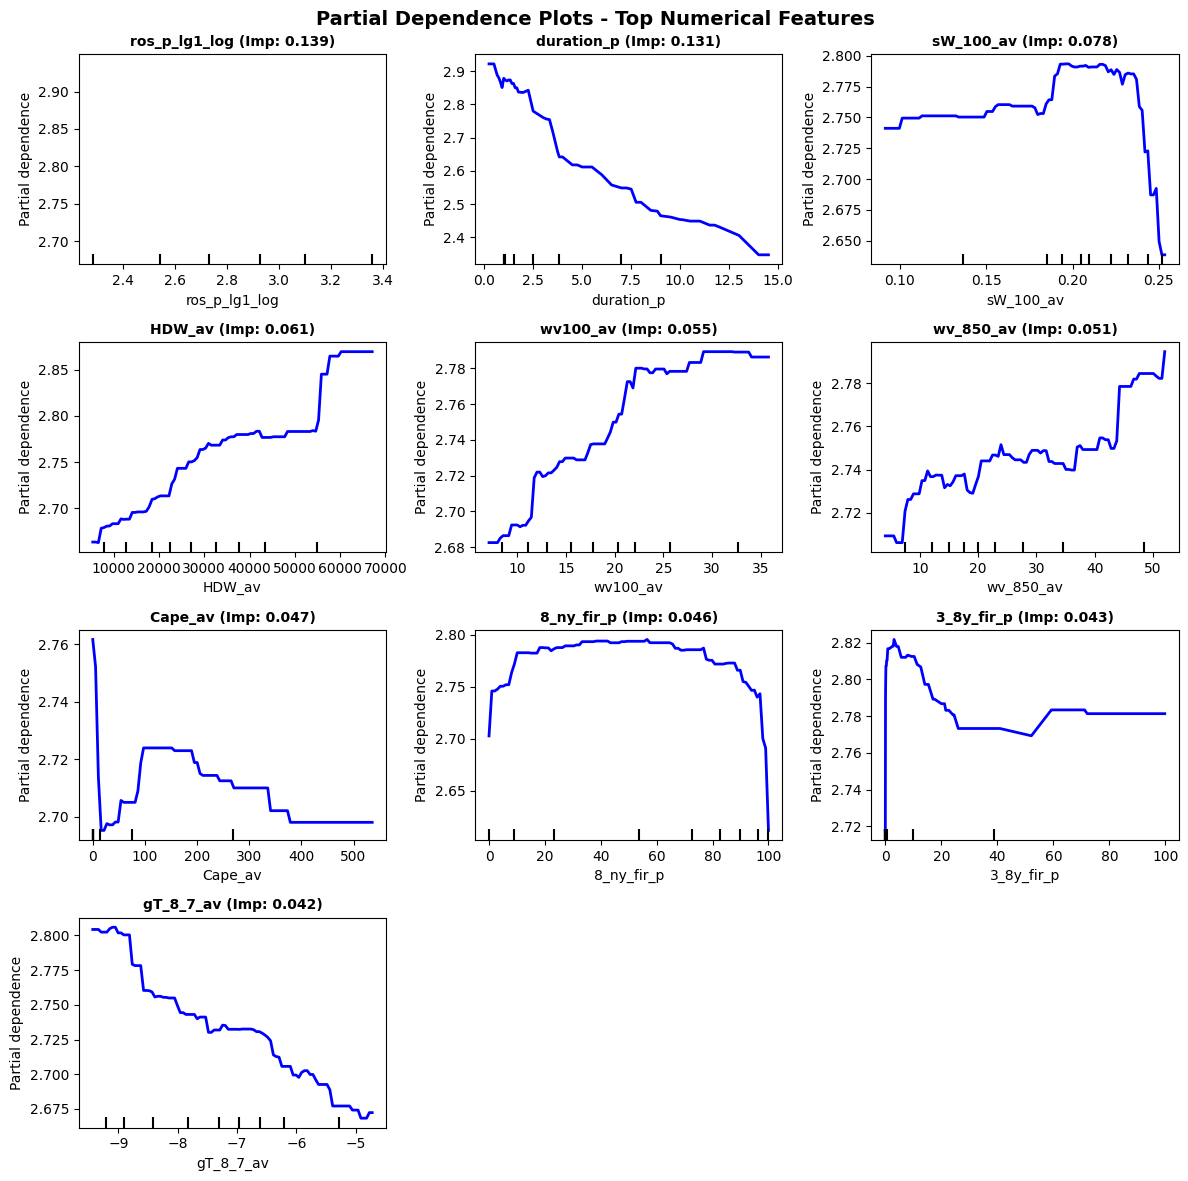


Comparing PDP and SHAP patterns for top 5 features...


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/inspection/_plot/partial_dependence.py:995: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


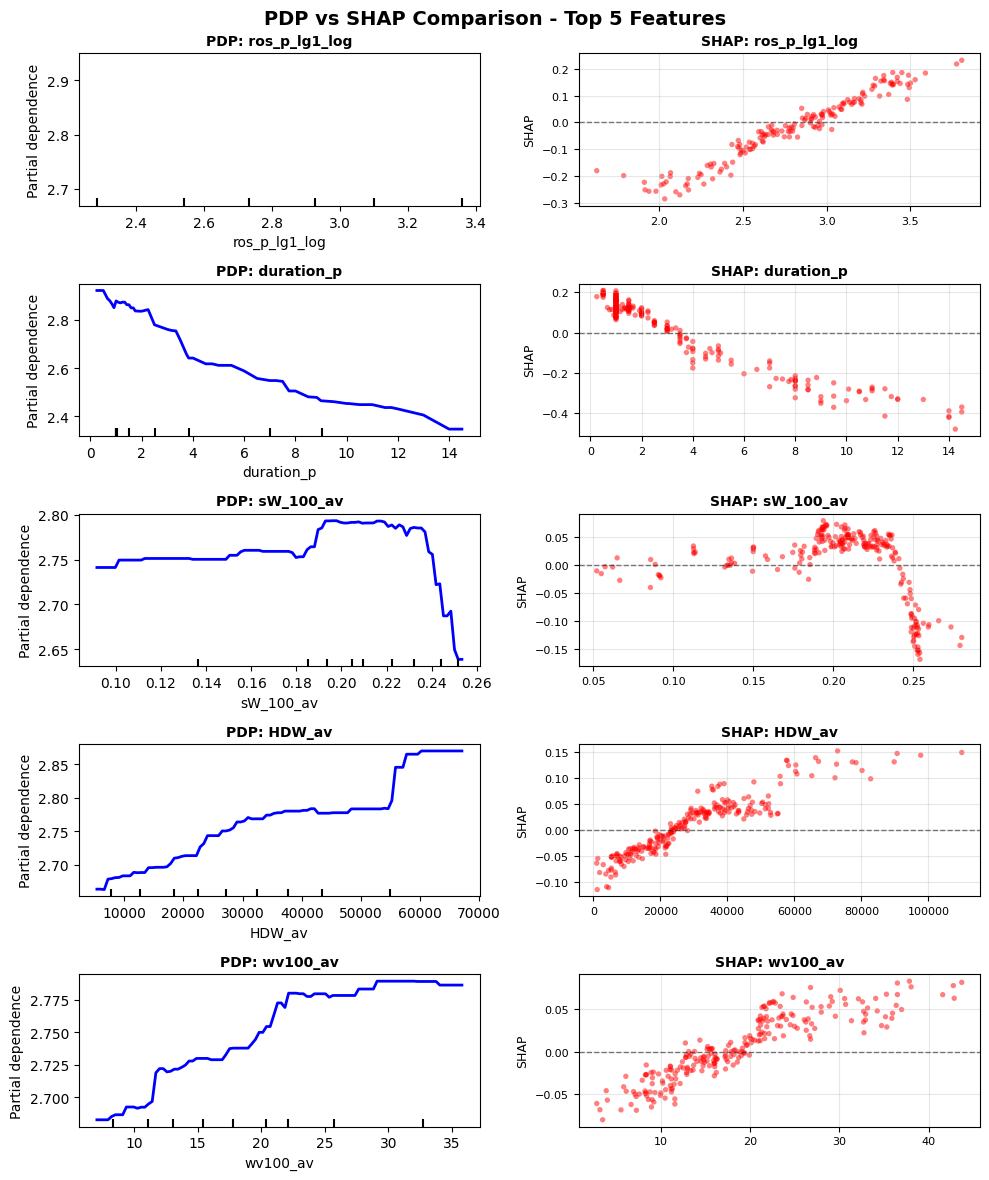


PDP Pattern Analysis
ros_p_lg1_log             | Weak            | Range: 0.0000
duration_p                | Decreasing      | Range: 0.4516
sW_100_av                 | Increasing      | Range: 0.1546


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/inspection/_plot/partial_dependence.py:995: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


HDW_av                    | Increasing      | Range: 0.2061
wv100_av                  | Increasing      | Range: 0.1068
wv_850_av                 | Weak            | Range: 0.0885
Cape_av                   | Weak            | Range: 0.0642
8_ny_fir_p                | Increasing      | Range: 0.1816
3_8y_fir_p                | Increasing      | Range: 0.1000
gT_8_7_av                 | Increasing      | Range: 0.1319

✓ PDP analysis completed!

Note: Categorical variables excluded from PDP analysis.
Categorical features in dataset: landform


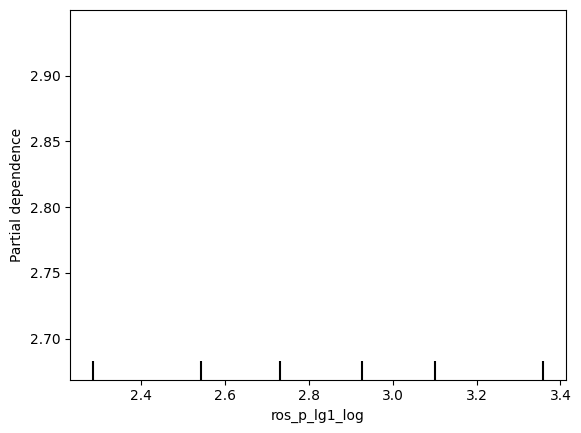

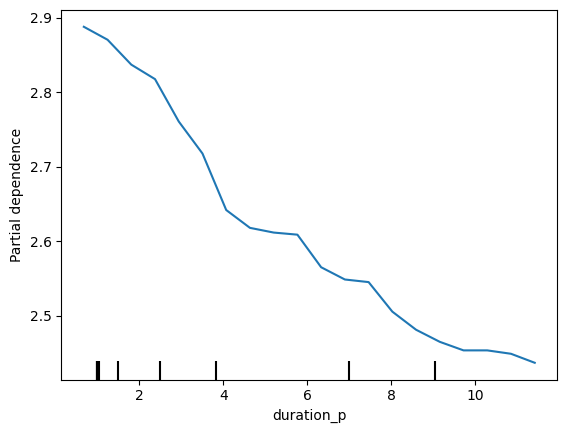

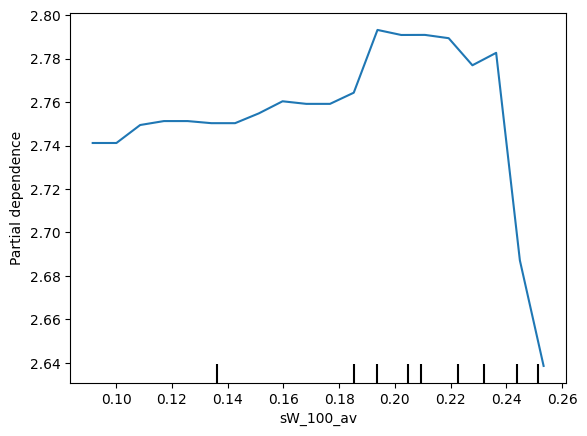

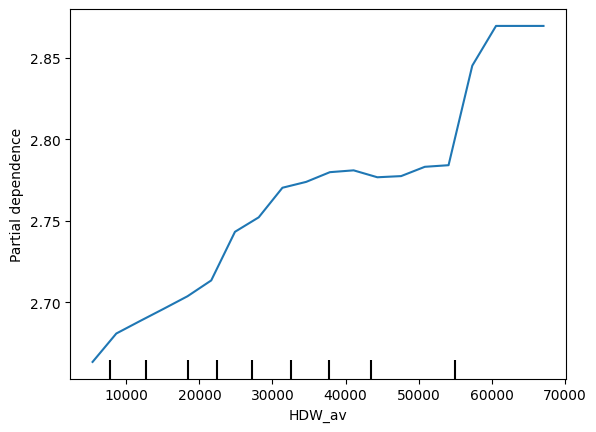

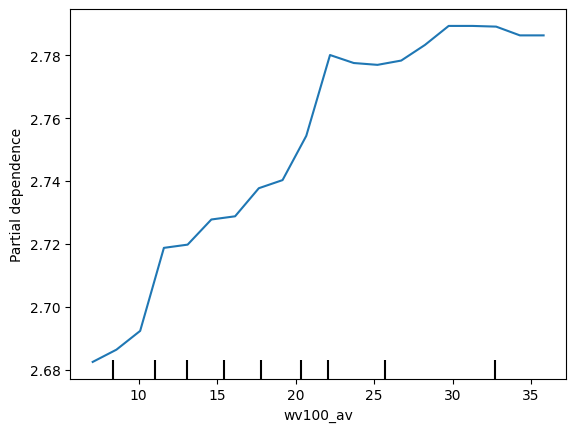

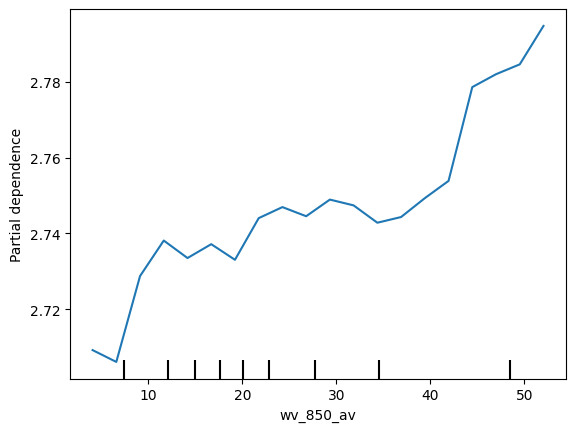

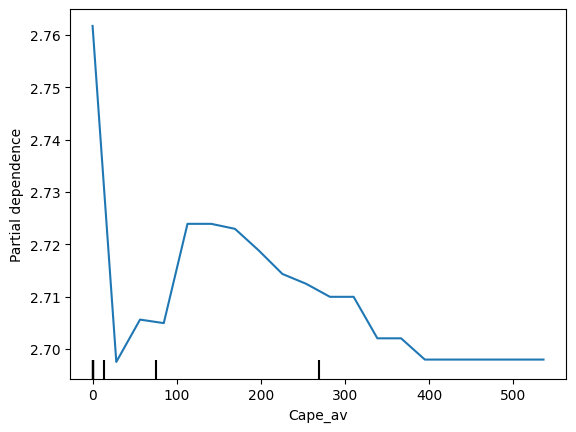

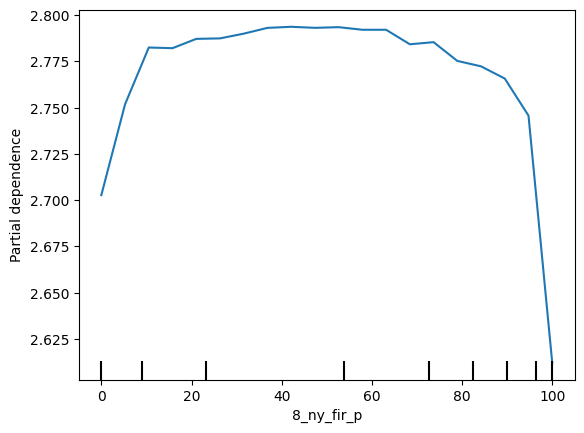

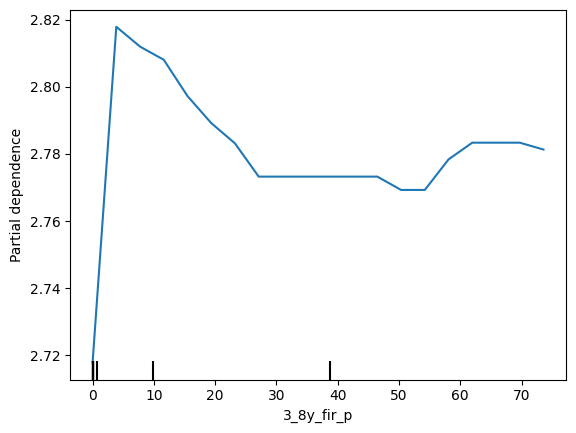

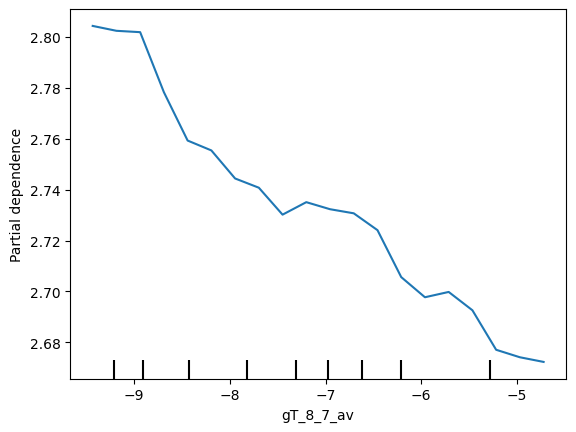

In [53]:
print("\n" + "="*50)
print("Partial Dependence Plots (PDPs)")
print("="*50)

# Separate numerical and categorical features
numerical_features = X_test_final.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_test_final.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")
if categorical_features:
    print(f"Categorical: {', '.join(categorical_features)}")

# Get top 10 numerical features by importance
top_numerical = [f for f in importances['feature'].head(15).tolist() 
                 if f in numerical_features][:10]

print(f"\nCreating PDPs for top {len(top_numerical)} numerical features...")

# -----------------------------
# 1D PDPs for Top Numerical Features
# -----------------------------
n_cols = 3
n_rows = math.ceil(len(top_numerical) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, feature in enumerate(top_numerical):
    ax = axes[idx]
    
    try:
        PartialDependenceDisplay.from_estimator(
            best_model,
            X_test_final,
            features=[feature],
            ax=ax,
            random_state=42,
            line_kw={"color": "blue", "linewidth": 2}
        )
        
        # Add mean and median lines
        feature_data = X_test_final[feature]
        ax.axvline(feature_data.mean(), color='red', linestyle='--', 
                  alpha=0.5, linewidth=1, label=f'Mean')
        ax.axvline(feature_data.median(), color='green', linestyle='--', 
                  alpha=0.5, linewidth=1, label=f'Median')
        
        feature_importance = importances.loc[importances['feature'] == feature, 'importance'].values[0]
        ax.set_title(f'{feature} (Imp: {feature_importance:.3f})', fontsize=10, fontweight='bold')
        ax.set_xlabel(feature, fontsize=9)
        ax.set_ylabel('Partial Dependence', fontsize=9)
        ax.legend(fontsize=7, loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)
        
    except Exception as e:
        print(f"Error plotting {feature}: {str(e)}")
        ax.text(0.5, 0.5, f'Error', ha='center', va='center', 
               transform=ax.transAxes, fontsize=10, color='red')
        ax.set_title(f'{feature} (Error)', fontsize=10)

# Hide unused subplots
for j in range(len(top_numerical), len(axes)):
    axes[j].axis('off')

plt.suptitle('Partial Dependence Plots - Top Numerical Features', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# -----------------------------
# PDP vs SHAP Comparison (Top 5)
# -----------------------------
print("\nComparing PDP and SHAP patterns for top 5 features...")

top_5 = top_numerical[:5]

fig, axes = plt.subplots(5, 2, figsize=(10, 12))

for idx, feature in enumerate(top_5):
    # Left: PDP
    ax_pdp = axes[idx, 0]
    try:
        PartialDependenceDisplay.from_estimator(
            best_model,
            X_test_final,
            features=[feature],
            ax=ax_pdp,
            random_state=42,
            line_kw={"color": "blue", "linewidth": 2}
        )
        ax_pdp.set_title(f'PDP: {feature}', fontsize=10, fontweight='bold')
        ax_pdp.set_xlabel('')
        ax_pdp.set_ylabel('PD', fontsize=9)
        ax_pdp.grid(True, alpha=0.3)
        ax_pdp.tick_params(labelsize=8)
    except Exception as e:
        ax_pdp.text(0.5, 0.5, 'Error', ha='center', va='center', 
                   transform=ax_pdp.transAxes, color='red')
    
    # Right: SHAP dependence
    ax_shap = axes[idx, 1]
    try:
        feature_idx = X_test_final.columns.get_loc(feature)
        feature_values = X_test_final[feature].values
        feature_shap = shap_values[:, feature_idx]
        
        valid_mask = ~np.isnan(feature_values)
        ax_shap.scatter(feature_values[valid_mask], feature_shap[valid_mask], 
                       alpha=0.5, s=15, color='red', edgecolors='none')
        ax_shap.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        ax_shap.set_title(f'SHAP: {feature}', fontsize=10, fontweight='bold')
        ax_shap.set_xlabel('')
        ax_shap.set_ylabel('SHAP', fontsize=9)
        ax_shap.grid(True, alpha=0.3)
        ax_shap.tick_params(labelsize=8)
    except Exception as e:
        ax_shap.text(0.5, 0.5, 'Error', ha='center', va='center', 
                    transform=ax_shap.transAxes, color='red')

plt.suptitle('PDP vs SHAP Comparison - Top 5 Features', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# -----------------------------
# PDP Pattern Analysis
# -----------------------------
print("\n" + "="*50)
print("PDP Pattern Analysis")
print("="*50)

for feature in top_numerical[:10]:
    try:
        pdp_results = PartialDependenceDisplay.from_estimator(
            best_model,
            X_test_final,
            features=[feature],
            grid_resolution=20
        )
        
        pdp_values = pdp_results.pd_results[0]['average']
        pdp_range = np.max(pdp_values) - np.min(pdp_values)
        
        # Trend analysis
        diffs = np.diff(pdp_values)
        if pdp_range < 0.1:
            trend = "Weak"
        elif np.sum(diffs > 0) > 0.8 * len(diffs):
            trend = "Increasing"
        elif np.sum(diffs < 0) > 0.8 * len(diffs):
            trend = "Decreasing"
        else:
            trend = "Non-monotonic"
        
        print(f"{feature:25} | {trend:15} | Range: {pdp_range:.4f}")
        
    except Exception as e:
        print(f"{feature:25} | Error: {str(e)[:30]}")

print("\n✓ PDP analysis completed!")
print("\nNote: Categorical variables excluded from PDP analysis.")
print("Categorical features in dataset:", ', '.join(categorical_features) if categorical_features else "None")

### KDE Density cloud of model results

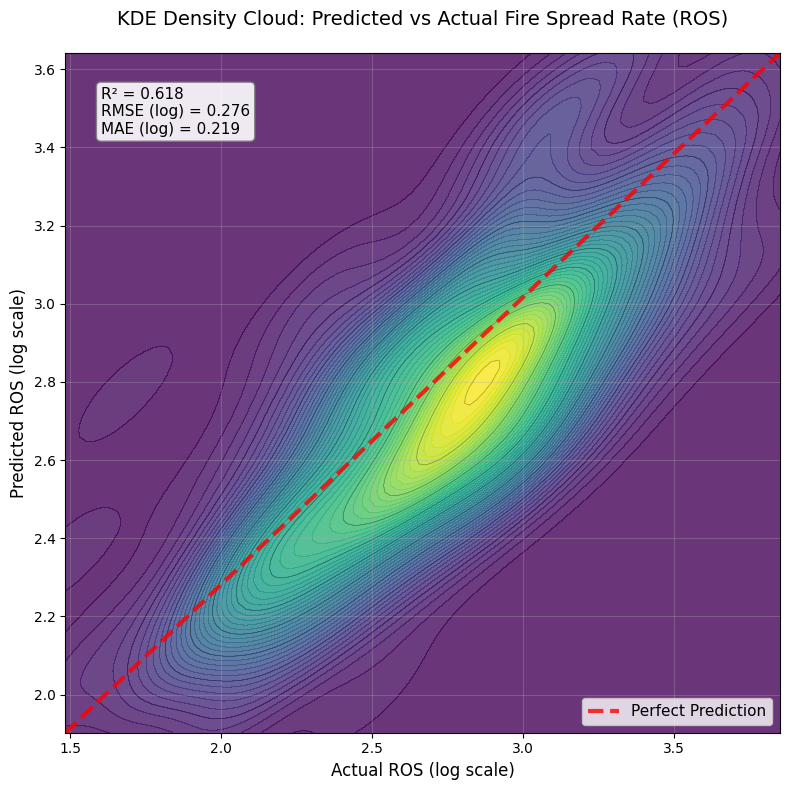

In [54]:
plt.figure(figsize=(8, 8))

# Create KDE density plot
from scipy.stats import gaussian_kde
import numpy as np

# Calculate the point density
x = y_test_log
y = y_pred_log
xy = np.vstack([x, y])

# Create meshgrid for density plot
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Calculate KDE on the grid
kde = gaussian_kde(xy)
z = np.reshape(kde(positions).T, xx.shape)

# Plot filled contour (density cloud)
plt.contourf(xx, yy, z, levels=50, cmap='viridis', alpha=0.8)

# Add contour lines for better definition
plt.contour(xx, yy, z, levels=10, colors='black', alpha=0.3, linewidths=0.5)

# Perfect prediction line
plt.plot([xmin, xmax], [ymin, ymax], 'r--', linewidth=3, label='Perfect Prediction', alpha=0.8)

plt.title('KDE Density Cloud: Predicted vs Actual Fire Spread Rate (ROS)', fontsize=14, pad=20)
plt.xlabel('Actual ROS (log scale)', fontsize=12)
plt.ylabel('Predicted ROS (log scale)', fontsize=12)

# Add metrics annotation
plt.text(0.05, 0.95, 
         f'R² = {r2:.3f}\n'
         f'RMSE (log) = {rmse_log:.3f}\n'
         f'MAE (log) = {mae_log:.3f}', 
         transform=plt.gca().transAxes,
         fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### GridSearch and GradientDescent for best parameters for ros_p log transformation.

In [55]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from itertools import product

class LogTransformOptimizer:
    """
    Optimizes transformation parameters for:
    1. log_c(y + 1) - finds optimal base c
    2. x*log(y + 1) - finds optimal multiplier x
    Now searches both parameters simultaneously
    """
    
    def __init__(self, X_train, y_train, X_test, y_test, 
                 param_dist=None, cv_splits=5, verbose=True):
        """
        Initialize the optimizer.
        
        Parameters:
        -----------
        X_train, y_train : Training data
        X_test, y_test : Test data
        param_dist : dict, XGBoost parameter distributions
        cv_splits : int, number of CV splits
        verbose : bool, whether to print progress
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cv_splits = cv_splits
        self.verbose = verbose
        
        # Default parameter distribution if not provided
        self.param_dist = param_dist or {
            'max_depth': [3, 5, 7, 9, 11],
            'learning_rate': uniform(0.01, 0.29),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 0.5),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(1, 2),
        }
        
        # Store results
        self.results = []
        self.best_c = None
        self.best_x = None
        self.best_rmse = np.inf  # Changed from best_r2 = -np.inf
        self.best_model = None
        
    def train_and_evaluate_combined(self, c_value, x_value):
        """
        Train XGBoost model with combined transformation: x*log_c(y + 1)
        Which is equivalent to: x * (log(y + 1) / log(c))
        
        Parameters:
        -----------
        c_value : float, base of logarithm (must be > 0 and ≠ 1)
        x_value : float, multiplier for log transformation
        
        Returns:
        --------
        rmse : float, RMSE on test set (original scale)
        """
        if self.verbose:
            print(f"\nTesting combination: c={c_value:.4f}, x={x_value:.4f}...")
        
        # Combined transformation: x * log_c(y + 1) = x * (log(y + 1) / log(c))
        y_train_log = x_value * (np.log(self.y_train + 1) / np.log(c_value))
        y_test_log = x_value * (np.log(self.y_test + 1) / np.log(c_value))
        
        return self._train_and_evaluate_common(y_train_log, y_test_log, c_value, x_value)
    
    def _train_and_evaluate_common(self, y_train_log, y_test_log, c_value=None, x_value=None):
        """Common training and evaluation logic."""
        
        # Base XGBoost model
        base_model = xgb.XGBRegressor(
            n_jobs=-1, 
            random_state=42,
            objective='reg:squarederror',
            tree_method='hist',
            enable_categorical=True
        )
        
        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=self.cv_splits)
        
        # Halving random search - changed scoring to negative RMSE
        search = HalvingRandomSearchCV(
            estimator=base_model,
            param_distributions=self.param_dist,
            factor=3,
            resource='n_estimators',
            max_resources=2000,
            min_resources=200,
            scoring='neg_root_mean_squared_error',  # Changed from 'r2'
            cv=tscv,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        # Train
        search.fit(self.X_train, y_train_log)
        
        # Evaluate on test set
        best_model = search.best_estimator_
        y_pred_log = best_model.predict(self.X_test)
        
        # Calculate RMSE in original scale (this is our main optimization target)
        y_pred_original = np.power(c_value, y_pred_log / x_value) - 1
        rmse_original = np.sqrt(mean_squared_error(self.y_test, y_pred_original))
        
        # Calculate other metrics for reference
        r2_log = r2_score(y_test_log, y_pred_log)
        mae_original = mean_absolute_error(self.y_test, y_pred_original)
        
        # Store results
        result = {
            'c': c_value,
            'x': x_value,
            'rmse_original': rmse_original,  # Now the primary metric
            'r2_log': r2_log,  # For reference
            'mae_original': mae_original,
            'best_params': search.best_params_,
            'model': best_model
        }
        self.results.append(result)
        
        if self.verbose:
            print(f"  RMSE (original): {rmse_original:.2f}")
            print(f"  R² (log scale): {r2_log:.4f}")
            print(f"  MAE (original): {mae_original:.2f}")
        
        # Update best if improved (lower RMSE is better)
        if rmse_original < self.best_rmse:
            self.best_rmse = rmse_original
            self.best_c = c_value
            self.best_x = x_value
            self.best_model = best_model
            if self.verbose:
                print(f"  *** New best combination! ***")
        
        return rmse_original  # Return RMSE instead of R²
    
    def grid_search_2d(self, c_range=None, x_range=None, num_points=10):
        """
        Perform 2D grid search over both parameters.
        
        Parameters:
        -----------
        c_range : tuple, (c_min, c_max) for log base
        x_range : tuple, (x_min, x_max) for multiplier
        num_points : int, number of points in each dimension
        
        Returns:
        --------
        best_c, best_x : optimal parameters
        """
        self.results = []  # Reset results
        
        # Default ranges
        if c_range is None:
            c_range = (1.5, 20.0)
        if x_range is None:
            x_range = (0.1, 5.0)
        
        if self.verbose:
            print(f"\n{'='*60}")
            print("Starting 2D Grid Search for Optimal Transformation Parameters")
            print(f"Searching c (log base) in: [{c_range[0]:.4f}, {c_range[1]:.4f}]")
            print(f"Searching x (multiplier) in: [{x_range[0]:.4f}, {x_range[1]:.4f}]")
            print(f"Grid size: {num_points} × {num_points} = {num_points**2} points")
            print(f"{'='*60}")
        
        # Generate grid points
        c_values = np.linspace(c_range[0], c_range[1], num_points)
        x_values = np.linspace(x_range[0], x_range[1], num_points)
        
        # Test all combinations
        for i, (c, x) in enumerate(product(c_values, x_values)):
            if self.verbose:
                print(f"\n--- Testing combination {i+1}/{len(c_values)*len(x_values)} ---")
            
            self.train_and_evaluate_combined(c, x)
        
        if self.verbose:
            print(f"\n{'='*60}")
            print(f"Grid Search Complete!")
            print(f"Best combination: c={self.best_c:.4f}, x={self.best_x:.4f}")
            print(f"Best RMSE: {self.best_rmse:.4f}")
            print(f"{'='*60}\n")
        
        return self.best_c, self.best_x
    
    def gradient_descent(self, c_init=2.0, x_init=1.0, learning_rate=0.1, 
                        tolerance=0.001, max_iterations=20, step_size=0.1):
        """
        Perform gradient descent to optimize both parameters simultaneously.
        
        Parameters:
        -----------
        c_init, x_init : initial parameter values
        learning_rate : learning rate for parameter updates
        tolerance : stop when improvements are smaller than this
        max_iterations : maximum number of iterations
        step_size : step size for finite difference gradient approximation
        
        Returns:
        --------
        best_c, best_x : optimal parameters
        """
        self.results = []  # Reset results
        
        current_c = c_init
        current_x = x_init
        current_rmse = self.train_and_evaluate_combined(current_c, current_x)
        
        if self.verbose:
            print(f"\n{'='*60}")
            print("Starting Gradient Descent for Optimal Transformation Parameters")
            print(f"Initial values: c={c_init:.4f}, x={x_init:.4f}")
            print(f"Learning rate: {learning_rate:.4f}")
            print(f"Tolerance: {tolerance:.4f}")
            print(f"{'='*60}")
        
        iteration = 0
        improvement = np.inf
        history = []
        
        while improvement > tolerance and iteration < max_iterations:
            iteration += 1
            
            if self.verbose:
                print(f"\n--- Iteration {iteration} ---")
                print(f"Current position: c={current_c:.4f}, x={current_x:.4f}, RMSE={current_rmse:.4f}")
            
            # Compute gradient using finite differences (negative gradient for minimization)
            grad_c = -self._compute_gradient(current_c, current_x, 'c', step_size)  # Negative for minimization
            grad_x = -self._compute_gradient(current_c, current_x, 'x', step_size)  # Negative for minimization
            
            if self.verbose:
                print(f"Gradient: ∇c={grad_c:.6f}, ∇x={grad_x:.6f}")
            
            # Update parameters
            new_c = current_c + learning_rate * grad_c
            new_x = current_x + learning_rate * grad_x
            
            # Apply constraints (c > 0 and c ≠ 1, x > 0)
            new_c = max(new_c, 1.001)  # Ensure c > 1 to avoid log issues
            new_x = max(new_x, 0.001)  # Ensure x > 0
            
            # Evaluate new position
            new_rmse = self.train_and_evaluate_combined(new_c, new_x)
            
            improvement = current_rmse - new_rmse  # Positive improvement means lower RMSE
            
            if self.verbose:
                print(f"New position: c={new_c:.4f}, x={new_x:.4f}, RMSE={new_rmse:.4f}")
                print(f"Improvement: {improvement:.6f}")
            
            # Update current position
            current_c, current_x, current_rmse = new_c, new_x, new_rmse
            history.append((current_c, current_x, current_rmse, grad_c, grad_x))
            
            # Adaptive learning rate: reduce if we're not improving much
            if improvement < tolerance / 10:
                learning_rate *= 0.8
                if self.verbose:
                    print(f"Reducing learning rate to {learning_rate:.4f}")
        
        if self.verbose:
            print(f"\n{'='*60}")
            print(f"Gradient Descent Complete!")
            print(f"Best combination: c={self.best_c:.4f}, x={self.best_x:.4f}")
            print(f"Best RMSE: {self.best_rmse:.4f}")
            print(f"Final learning rate: {learning_rate:.4f}")
            print(f"{'='*60}\n")
        
        # Plot convergence history
        self._plot_convergence(history)
        
        return self.best_c, self.best_x
    
    def _compute_gradient(self, c, x, param, step_size):
        """
        Compute gradient using finite differences.
        
        Parameters:
        -----------
        c, x : current parameter values
        param : which parameter to compute gradient for ('c' or 'x')
        step_size : step size for finite differences
        
        Returns:
        --------
        gradient : float
        """
        if param == 'c':
            # Evaluate at c + step_size
            rmse_plus = self.train_and_evaluate_combined(c + step_size, x)
            # Evaluate at c - step_size  
            rmse_minus = self.train_and_evaluate_combined(c - step_size, x)
        else:  # param == 'x'
            # Evaluate at x + step_size
            rmse_plus = self.train_and_evaluate_combined(c, x + step_size)
            # Evaluate at x - step_size
            rmse_minus = self.train_and_evaluate_combined(c, x - step_size)
        
        # Finite difference gradient
        gradient = (rmse_plus - rmse_minus) / (2 * step_size)
        
        return gradient
    
    def _plot_convergence(self, history):
        """Plot convergence history of gradient descent."""
        if not history:
            return
            
        iterations = range(1, len(history) + 1)
        c_values = [h[0] for h in history]
        x_values = [h[1] for h in history]
        rmse_values = [h[2] for h in history]
        grad_c = [h[3] for h in history]
        grad_x = [h[4] for h in history]
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: RMSE convergence
        ax1.plot(iterations, rmse_values, 'o-', linewidth=2, markersize=6)
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('RMSE')
        ax1.set_title('RMSE Convergence')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Parameter convergence
        ax2.plot(iterations, c_values, 'o-', linewidth=2, markersize=6, label='c')
        ax2.plot(iterations, x_values, 'o-', linewidth=2, markersize=6, label='x')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Parameter Value')
        ax2.set_title('Parameter Convergence')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Gradient magnitudes
        ax3.plot(iterations, np.abs(grad_c), 'o-', linewidth=2, markersize=6, label='|∇c|')
        ax3.plot(iterations, np.abs(grad_x), 'o-', linewidth=2, markersize=6, label='|∇x|')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Gradient Magnitude')
        ax3.set_title('Gradient Convergence')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_yscale('log')
        
        # Plot 4: Parameter path
        ax4.plot(c_values, x_values, 'o-', linewidth=2, markersize=6)
        ax4.plot(c_values[0], x_values[0], 'go', markersize=10, label='Start')
        ax4.plot(c_values[-1], x_values[-1], 'ro', markersize=10, label='End')
        ax4.set_xlabel('Log Base (c)')
        ax4.set_ylabel('Multiplier (x)')
        ax4.set_title('Parameter Search Path')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_results_2d(self):
        """Create 2D contour plot of RMSE scores vs both parameters."""
        if not self.results:
            print("No results to plot. Run optimization first.")
            return
        
        # Extract parameter values and RMSE scores
        c_values = [r['c'] for r in self.results]
        x_values = [r['x'] for r in self.results]
        rmse_scores = [r['rmse_original'] for r in self.results]
        
        # Create grid for contour plot
        unique_c = np.unique(c_values)
        unique_x = np.unique(x_values)
        
        if len(unique_c) > 1 and len(unique_x) > 1:
            # Create meshgrid
            C, X = np.meshgrid(unique_c, unique_x)
            
            # Reshape RMSE scores to match grid
            RMSE = np.full(C.shape, np.nan)
            for i, c in enumerate(unique_c):
                for j, x in enumerate(unique_x):
                    # Find matching result
                    for result in self.results:
                        if abs(result['c'] - c) < 1e-6 and abs(result['x'] - x) < 1e-6:
                            RMSE[j, i] = result['rmse_original']
                            break
            
            # Create plot
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Contour plot
            contour = ax.contourf(C, X, RMSE, levels=20, cmap='viridis')
            ax.contour(C, X, RMSE, levels=10, colors='black', alpha=0.3, linewidths=0.5)
            
            # Mark best point
            ax.plot(self.best_c, self.best_x, 'ro', markersize=10, 
                   label=f'Best: c={self.best_c:.3f}, x={self.best_x:.3f}')
            
            ax.set_xlabel('Log Base (c)', fontsize=12)
            ax.set_ylabel('Log Multiplier (x)', fontsize=12)
            ax.set_title('RMSE vs Transformation Parameters\n(Combined: x*log_c(y+1))', fontsize=14)
            plt.colorbar(contour, ax=ax, label='RMSE')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough unique parameter values for 2D plot. Try grid search.")
    
    def plot_results_1d(self):
        """Create 1D plots showing effect of each parameter individually."""
        if not self.results:
            print("No results to plot. Run optimization first.")
            return
        
        # Find results where one parameter is fixed near the optimal value
        c_near_optimal = [r for r in self.results if abs(r['x'] - self.best_x) < 0.1]
        x_near_optimal = [r for r in self.results if abs(r['c'] - self.best_c) < 0.5]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Effect of c with x ≈ best_x
        if c_near_optimal:
            c_near_optimal.sort(key=lambda r: r['c'])
            c_vals = [r['c'] for r in c_near_optimal]
            rmse_vals = [r['rmse_original'] for r in c_near_optimal]
            
            ax1.plot(c_vals, rmse_vals, 'o-', linewidth=2, markersize=6)
            ax1.axvline(self.best_c, color='r', linestyle='--', 
                       label=f'Best c = {self.best_c:.3f}')
            ax1.set_xlabel('Log Base (c)', fontsize=12)
            ax1.set_ylabel('RMSE', fontsize=12)
            ax1.set_title(f'Effect of Log Base (x ≈ {self.best_x:.3f})', fontsize=14)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
        
        # Plot 2: Effect of x with c ≈ best_c
        if x_near_optimal:
            x_near_optimal.sort(key=lambda r: r['x'])
            x_vals = [r['x'] for r in x_near_optimal]
            rmse_vals = [r['rmse_original'] for r in x_near_optimal]
            
            ax2.plot(x_vals, rmse_vals, 'o-', linewidth=2, markersize=6, color='orange')
            ax2.axvline(self.best_x, color='r', linestyle='--', 
                       label=f'Best x = {self.best_x:.3f}')
            ax2.set_xlabel('Log Multiplier (x)', fontsize=12)
            ax2.set_ylabel('RMSE', fontsize=12)
            ax2.set_title(f'Effect of Log Multiplier (c ≈ {self.best_c:.3f})', fontsize=14)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_final_model_metrics(self):
        """Get comprehensive metrics for the best model."""
        if self.best_model is None:
            print("No model trained yet. Run optimization first.")
            return None
        
        # Transform with best parameters: x*log_c(y + 1)
        y_train_log = self.best_x * (np.log(self.y_train + 1) / np.log(self.best_c))
        y_test_log = self.best_x * (np.log(self.y_test + 1) / np.log(self.best_c))
        y_pred_log = self.best_model.predict(self.X_test)
        
        # Inverse transformation: y = c^(y_pred_log / x) - 1
        y_pred_original = np.power(self.best_c, y_pred_log / self.best_x) - 1
        
        # Metrics
        metrics = {
            'best_c': self.best_c,
            'best_x': self.best_x,
            'rmse_original': np.sqrt(mean_squared_error(self.y_test, y_pred_original)),
            'mae_original': mean_absolute_error(self.y_test, y_pred_original),
            'r2_original': r2_score(self.y_test, y_pred_original),
            'r2_log': r2_score(y_test_log, y_pred_log),
            'rmse_log': np.sqrt(mean_squared_error(y_test_log, y_pred_log)),
            'mae_log': mean_absolute_error(y_test_log, y_pred_log),
        }
        
        return metrics


# Example usage for combined optimization:

# Initialize optimizer
optimizer = LogTransformOptimizer(
    X_train_final, y_train_final, 
    X_test_final, y_test_final,
    verbose=True
)

"""# Option 1: 2D Grid Search (comprehensive but slower)
print("=== Performing 2D Grid Search ===")
best_c, best_x = optimizer.grid_search_2d(
    c_range=(35, 50.0), 
    x_range=(15, 30.0), 
    num_points=4  # 8x8 = 64 combinations
)"""

# Option 2: Gradient Descent (faster, good for refinement)
print("\n=== Performing Gradient Descent ===")
best_c, best_x = optimizer.gradient_descent(
    c_init=40, 
    x_init=20, 
    learning_rate=0.0001,
    tolerance=0.0001,
    max_iterations=50,
    step_size=0.0001
)

# Plot results
optimizer.plot_results_2d()  # 2D contour plot
optimizer.plot_results_1d()  # 1D parameter effect plots

# Get final metrics
metrics = optimizer.get_final_model_metrics()
print("\nFinal Model Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Access the best model
best_model = optimizer.best_model

# Use the optimal transformation for final training
y_train_optimal = best_x * (np.log(y_train_final + 1) / np.log(best_c))
y_test_optimal = best_x * (np.log(y_test_final + 1) / np.log(best_c))

# To transform predictions back to original scale:
# y_original = c^(y_pred / x) - 1


=== Performing Gradient Descent ===

Testing combination: c=40.0000, x=20.0000...
  RMSE (original): 740.83
  R² (log scale): 0.6308
  MAE (original): 425.02
  *** New best combination! ***

Starting Gradient Descent for Optimal Transformation Parameters
Initial values: c=40.0000, x=20.0000
Learning rate: 0.0001
Tolerance: 0.0001

--- Iteration 1 ---
Current position: c=40.0000, x=20.0000, RMSE=740.8321

Testing combination: c=40.0001, x=20.0000...


KeyboardInterrupt: 